#FinBERT情感数据打分

In [3]:
%pip install transformers torch pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 19.2 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 19.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 18.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.2
    Uninstalling sympy-1.13.2:
      Successfully uninstalled sympy-1.13.2
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

# 1. 加载数据
df = pd.read_csv("/01文本抓取与预处理/trump_merged_2017_2025.csv")

# 2. 加载 FinBERT 模型和 tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# 3. 创建 pipeline
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# 4. 定义函数用于逐条打分（可加速处理）
def analyze_sentiment(text):
    try:
        result = nlp(text[:512])[0]  # 限制BERT长度
        return pd.Series([result["label"], result["score"]])
    except Exception:
        return pd.Series(["ERROR", 0])

# 5. 执行情绪分析
df[["sentiment", "confidence"]] = df["clean_text"].apply(analyze_sentiment)

# 6. 保存结果
df.to_csv("trump_merged_finbert_sentiment.csv", index=False)
print("✅ 分析完成，结果已保存：trump_merged_finbert_sentiment.csv")


Device set to use mps:0


✅ 分析完成，结果已保存：trump_merged_finbert_sentiment.csv


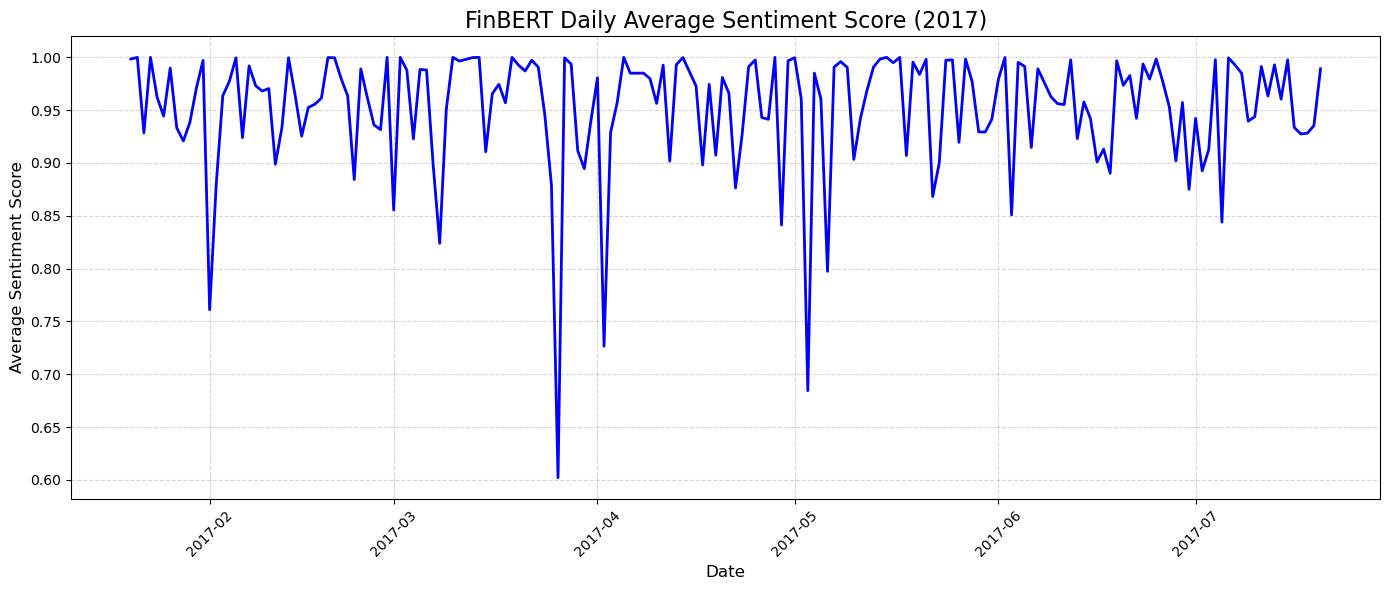

In [18]:
# 5. 可视化绘图
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(daily_sentiment['date'], daily_sentiment['sentiment_score'], color='blue', linewidth=2)
plt.title('FinBERT Daily Average Sentiment Score (2017)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("finbert_sentiment_trend_2017.png", dpi=300)

plt.show()

<Figure size 1400x600 with 0 Axes>

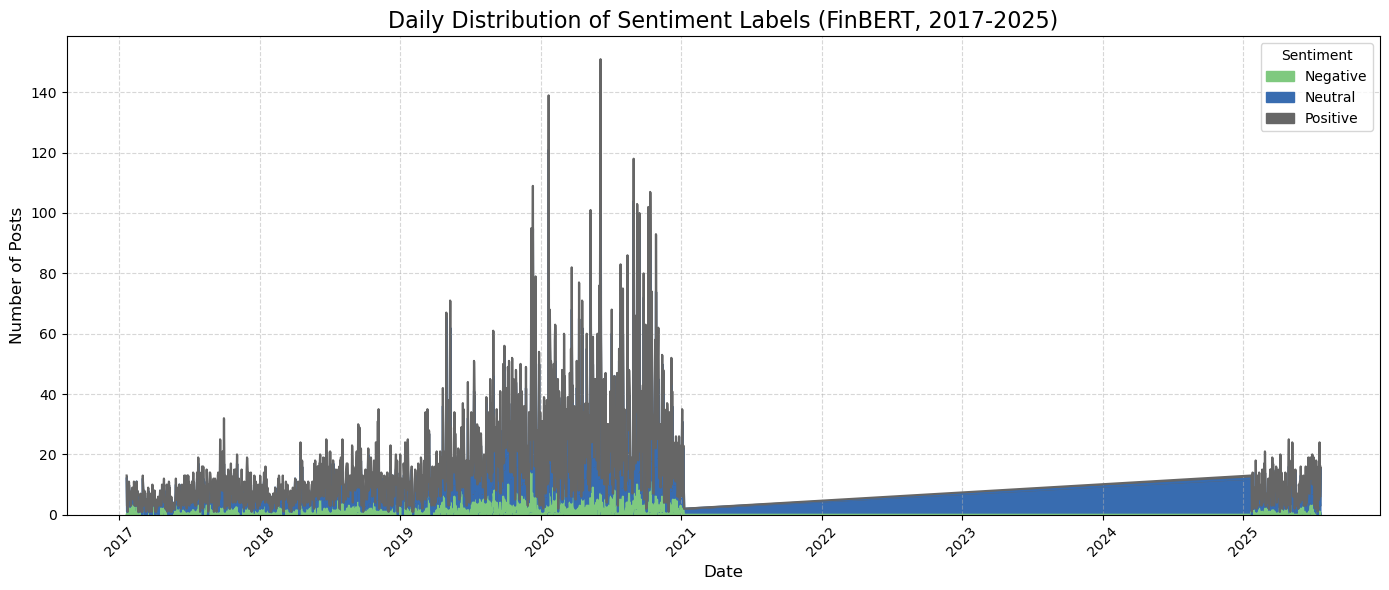

In [ ]:
import matplotlib.pyplot as plt

#每日情绪标签分布趋势图（FinBERT）

# 1. 读取 FinBERT 输出数据（包含 date, sentiment_label 字段）
df = pd.read_csv("/02情感分析/trump_merged_finbert_sentiment.csv")

# 2. 转换时间格式，只保留日期部分
df['date'] = pd.to_datetime(df['date']).dt.date


# 4. 按日期与情绪标签统计数量
sentiment_counts = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

# 5. 绘制堆叠面积图
plt.figure(figsize=(14, 6))
sentiment_counts.plot(kind='area', stacked=True, figsize=(14, 6), colormap='Accent')

plt.title('Daily Distribution of Sentiment Labels (FinBERT, 2017-2025)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(title='Sentiment')
#plt.savefig("finbert_sentiment_distribution_2017_2025.png", dpi=300)
plt.show()


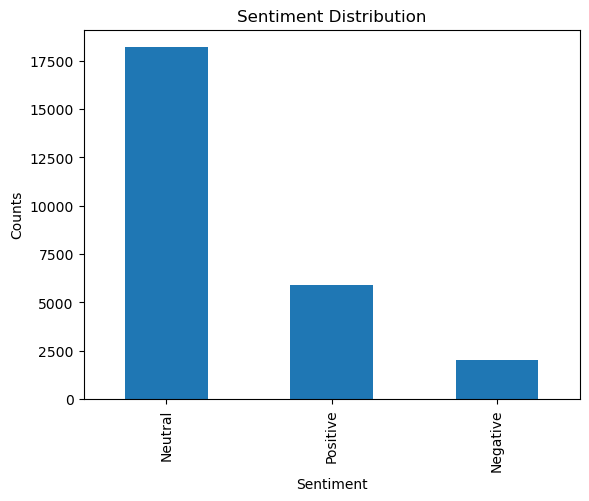

In [8]:
#查看df中sentiment列的数据情况
df['sentiment'].value_counts()
#可视化情感分布
import matplotlib.pyplot as plt
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.show()

In [ ]:
import pandas as pd

# === 读取数据 ===
df = pd.read_csv("/02情感分析/trump_merged_finbert_sentiment.csv")

# === 清洗情绪列 ===
df["sentiment"] = df["sentiment"].str.strip().str.lower()

# === 处理时间字段 ===
df["date"] = pd.to_datetime(df["date"], errors='coerce')
df["day"] = df["date"].dt.date

# === 检查情绪种类 ===
print("情绪类别有：", df["sentiment"].unique())

# === 每日情绪计数 ===
daily_sentiment = df.groupby("day")["sentiment"].value_counts().unstack(fill_value=0)

# === 推文总数 ===
daily_sentiment["total"] = daily_sentiment.sum(axis=1)

# === 比例特征（强制浮点除法） ===
for sentiment in ["positive", "negative", "neutral"]:
    if sentiment not in daily_sentiment.columns:
        daily_sentiment[sentiment] = 0
    daily_sentiment[f"{sentiment}_ratio"] = daily_sentiment[sentiment] / daily_sentiment["total"].astype(float)


# === 6. 导出结果 ===
daily_sentiment = daily_sentiment.reset_index()
daily_sentiment.head(20)
daily_sentiment.to_csv("daily_sentiment_ratios.csv", index=False)



情绪类别有： ['neutral' 'positive' 'negative']
